In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
from torchvision.transforms import ToTensor
import torchvision
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from time import time
import numpy as np
import cv2
import seaborn as sns
import os

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
input_size = 784 # 28x28
torch.manual_seed(42)
num_epochs = 20
batch_size = 128
eta = .001
validation_size = 52*(10**3)

### Build a target model

In [3]:
def MNIST_data_generation(validation_size):
    training_data = datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_data = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor()
    )


    train_size = len(training_data) - validation_size

    training_data, validation_data = random_split(training_data, [train_size, validation_size])

    train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=validation_data, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

    print(f"Training Data Size: {len(training_data)}, Validation Data Size: {len(validation_data)}, Test Data Size: {len(test_data)}")
    return train_loader, validation_loader, test_loader

In [4]:
class Net(nn.Module):
      def __init__(self, input_size, hidden_size, num_classes):
          super().__init__()
          self.fc1 = nn.Linear(input_size, hidden_size)
          self.fc2 = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
          x = x.view(x.size(0), -1)
          x = self.fc1(x)
          x = F.relu(x)
          x = self.fc2(x)
          return F.softmax(x, dim=1)
      
class Convolution_Net(nn.Module):
      def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

      def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [5]:
train_loader, validation_loader, test_loader  = MNIST_data_generation(validation_size)

Training Data Size: 8000, Validation Data Size: 52000, Test Data Size: 10000


In [6]:
@torch.no_grad()
def get_loss(loader, criterion, model):
    loss_mini_batch_list = []
    for index, (data, labels) in enumerate(loader):
      # Giving data to cuda
        data = data.reshape(data.size(0), -1).to(device=device)
        #Recall that each MNIST image is originally a 28 x 28 matrix which was in the last 2 dimensions of data
        #The "-1" vectorizes the last 2 dimensions of data
        #So now,  data is now a mini-batch-size x (28^2) matrix - as what the "model" i.e the net requires to get as input
        labels = labels.to(device=device)
        # forward pass
        y_hat = model(data)
        loss = criterion(y_hat, labels)
        loss_mini_batch_list.append(loss)
    return loss_mini_batch_list


def get_accuracy(loader, model):
    correct_pred = 0
    num_samples = 0
    #model.eval()
    for data, labels in loader:
        data = data.reshape(-1, 28*28).to(device=device)
        labels = labels.to(device=device)

        scores = model(data)
        _, preds = scores.max(1)
        #print(preds.shape)
        #print(labels.shape)
        correct_pred += (preds == labels).sum().item()
        num_samples += labels.size(0)


    return (float(correct_pred)/float(num_samples))*100

    #print(f'There were {correct_pred} correct predictions out of {num_samples} samples with and accuracy of {float(correct_pred)/float(num_samples)*100:.2f}')
    #model.train()


In [7]:

def Neural_Training (epochs, lr, model, train_loader, criterion, optimizer, test_loader):
    train_loss_dynamics = []
    test_loss_dynamics = []
    train_accuracy_dynamics = []
    test_accuracy_dynamics = []
    #validation_loss_dynamics = []
    accuracy = []

    for epoch in range(epochs):
        training_loss_list = []
        for index, (data, labels) in enumerate(train_loader):
            # Giving data to cuda
            data = data.reshape(data.size(0), -1).to(device=device)
            labels = labels.to(device=device)
            # forward pass
            y_hat = model(data)
            loss = criterion(y_hat, labels)
            loss.requires_grad_(True)

            #Computing The Gradient On The Mini-Batch Loss
            loss.backward()
            
            #Computing The ADAM Update Using The Above Computed Stochastic Gradient
            optimizer.step()
            optimizer.zero_grad()


        #validation_loss = torch.stack(get_loss(validation_loader, criterion, model)).mean().item()
        training_loss = torch.stack(get_loss(train_loader, criterion, model)).mean().item()
        test_loss = torch.stack(get_loss(test_loader, criterion, model)).mean().item()
        #The above computes the empirical and test loss on the whole training and the test data respectively.

        train_accuracy_dynamics.append(get_accuracy(train_loader,model))
        test_accuracy_dynamics.append(get_accuracy(test_loader,model))
        #The above computes the empirical and test classification risk on the whole training and the test data respectively.

        train_loss_dynamics.append(training_loss)
        test_loss_dynamics.append(test_loss)
        #validation_loss_dynamics.append(validation_loss)

        print (f'Epoch [{epoch+1}/{epochs}]: The training loss is {training_loss:.4f}')

    return train_accuracy_dynamics, train_loss_dynamics, test_accuracy_dynamics, test_loss_dynamics

In [8]:
def draw_loss_accuracy(train_loss, train_accuracy, test_loss, test_accuracy):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

#axs[0,0].plot(u_train_loss, '-bx')
    axs[0,0].plot(train_loss, '-rx')
    axs[0,0].set_xlabel('epoch')
    axs[0,0].set_ylabel('loss')
    #axs[0,0].legend(['Underparameterized Model', 'Overparameterized Model'])
    axs[0,0].set_title('Training Loss vs Epochs')
    axs[0,0].yaxis.grid(True)

#axs[0,1].plot(u_test_loss, '-bx')
    axs[0,1].plot(test_loss, '-rx')
    axs[0,1].set_xlabel('epoch')
    axs[0,1].set_ylabel('loss')
    #axs[0,1].legend(['Underparameterized Model', 'Overparameterized Model'])
    axs[0,1].set_title('Test Loss vs Epochs')
    axs[0,1].yaxis.grid(True)

#axs[1,0].plot(u_train_acc, '-bx')
    axs[1,0].plot(train_accuracy, '-rx')
    axs[1,0].set_xlabel('epoch')
    axs[1,0].set_ylabel('loss')
    #axs[1,0].legend(['Underparameterized Model', 'Overparameterized Model'])
    axs[1,0].set_title('Classification Accuracy On Training Data vs Epochs')
    axs[1,0].yaxis.grid(True)

#axs[1,1].plot(u_test_acc, '-bx')
    axs[1,1].plot(test_accuracy, '-rx')
    axs[1,1].set_xlabel('epoch')
    axs[1,1].set_ylabel('accuracy')
    #axs[1,1].legend(['Underparameterized Model', 'Overparameterized Model'])
    axs[1,1].set_title('Classification Accuracy On Test Data vs Epochs')
    axs[1,1].yaxis.grid(True)

plt.tight_layout()


<Figure size 640x480 with 0 Axes>

In [10]:
o_model = Net(input_size=input_size, hidden_size=1500, num_classes=10).to(device)
summary(o_model, (1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1500]       1,177,500
            Linear-2                   [-1, 10]          15,010
Total params: 1,192,510
Trainable params: 1,192,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 4.55
Estimated Total Size (MB): 4.56
----------------------------------------------------------------


In [15]:

o_train_acc, o_train_loss, o_test_acc, o_test_loss = Neural_Training(num_epochs, eta, o_model, train_loader, nn.CrossEntropyLoss(), torch.optim.Adam(o_model.parameters(), lr=eta),
                           test_loader)

Epoch [1/20]: The training loss is 1.6329
Epoch [2/20]: The training loss is 1.5568
Epoch [3/20]: The training loss is 1.5338
Epoch [4/20]: The training loss is 1.5200
Epoch [5/20]: The training loss is 1.5133
Epoch [6/20]: The training loss is 1.5036
Epoch [7/20]: The training loss is 1.5019
Epoch [8/20]: The training loss is 1.4943
Epoch [9/20]: The training loss is 1.4909
Epoch [10/20]: The training loss is 1.4868
Epoch [11/20]: The training loss is 1.4862
Epoch [12/20]: The training loss is 1.4850
Epoch [13/20]: The training loss is 1.4816
Epoch [14/20]: The training loss is 1.4801
Epoch [15/20]: The training loss is 1.4788
Epoch [16/20]: The training loss is 1.4780
Epoch [17/20]: The training loss is 1.4775
Epoch [18/20]: The training loss is 1.4765
Epoch [19/20]: The training loss is 1.4767
Epoch [20/20]: The training loss is 1.4759


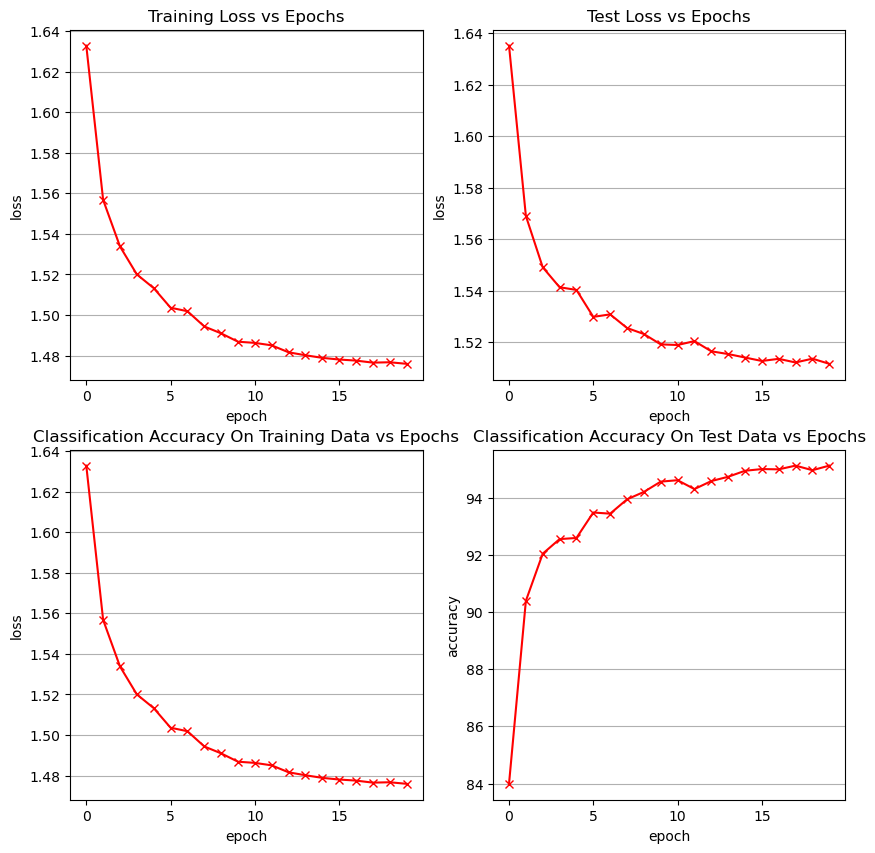

In [16]:
draw_loss_accuracy(o_train_loss, o_train_loss, o_test_loss, o_test_acc)

In [17]:
## 保存模型
torch.save(o_model, 'simple_model.pth')



In [9]:
## 读取模型
o_model = torch.load('simple_model.pth')

In [15]:
get_accuracy(test_loader,o_model)

95.12

In [20]:
o_model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.0110, -0.0096, -0.0194,  ...,  0.0244, -0.0186,  0.0118],
                      [-0.0061,  0.0233, -0.0160,  ...,  0.0348, -0.0215,  0.0044],
                      [-0.0071,  0.0019,  0.0007,  ...,  0.0242,  0.0239, -0.0050],
                      ...,
                      [-0.0208,  0.0269,  0.0302,  ..., -0.0125,  0.0350,  0.0105],
                      [-0.0310,  0.0087,  0.0204,  ..., -0.0087, -0.0004,  0.0329],
                      [-0.0192, -0.0118, -0.0134,  ...,  0.0008, -0.0250, -0.0183]],
                     device='cuda:0')),
             ('fc1.bias',
              tensor([ 0.0153,  0.0129, -0.0272,  ..., -0.0116,  0.0098,  0.0672],
                     device='cuda:0')),
             ('fc2.weight',
              tensor([[ 0.0443, -0.0390,  0.0348,  ..., -0.0860,  0.0634,  0.0429],
                      [-0.0022, -0.0236,  0.0359,  ...,  0.0375, -0.1065, -0.0148],
                      [ 0.0635,  0.0314, -0.1122,  ...,

In [103]:

f1 = o_model.state_dict()['fc1.weight'].clone()
f2 = o_model.state_dict()['fc2.weight'].clone()
b1 = o_model.state_dict()['fc1.bias'].clone()
b2 = o_model.state_dict()['fc2.bias'].clone()
print("f1",f1)
print('f2',f2)
noised_weight_f1 = f1.cpu().numpy()+np.random.normal(0,0.5,f1.cpu().numpy().shape)
noised_weight_f2 = f2.cpu().numpy()+np.random.normal(0,0.5,f2.cpu().numpy().shape)
print("noised f1",noised_weight_f1)
print('noised f2',noised_weight_f2)

f1 tensor([[ 0.0110, -0.0096, -0.0194,  ...,  0.0244, -0.0186,  0.0118],
        [-0.0061,  0.0233, -0.0160,  ...,  0.0348, -0.0215,  0.0044],
        [-0.0071,  0.0019,  0.0007,  ...,  0.0242,  0.0239, -0.0050],
        ...,
        [-0.0208,  0.0269,  0.0302,  ..., -0.0125,  0.0350,  0.0105],
        [-0.0310,  0.0087,  0.0204,  ..., -0.0087, -0.0004,  0.0329],
        [-0.0192, -0.0118, -0.0134,  ...,  0.0008, -0.0250, -0.0183]],
       device='cuda:0')
f2 tensor([[ 0.0443, -0.0390,  0.0348,  ..., -0.0860,  0.0634,  0.0429],
        [-0.0022, -0.0236,  0.0359,  ...,  0.0375, -0.1065, -0.0148],
        [ 0.0635,  0.0314, -0.1122,  ...,  0.0208, -0.0271,  0.0501],
        ...,
        [-0.0908, -0.0073, -0.0253,  ..., -0.0037, -0.0142, -0.1259],
        [ 0.0256,  0.0181,  0.0356,  ..., -0.0078,  0.0100, -0.0482],
        [ 0.0260,  0.0255,  0.0412,  ...,  0.0356, -0.0291, -0.1018]],
       device='cuda:0')
noised f1 [[-6.75176677e-02 -1.79641502e-01  1.67290992e-01 ...  1.46063662e+0

In [104]:

o_model.fc1.weight.data= torch.from_numpy(noised_weight_f1).to(torch.float32).to(device)
o_model.fc2.weight.data = torch.from_numpy(noised_weight_f2).to(torch.float32).to(device)

In [106]:
get_accuracy(test_loader,o_model)

17.849999999999998

In [112]:
torch.save(o_model, 'distorted_model.pth')

In [1]:
o_model = torch.load('distorted_model.pth')

NameError: name 'torch' is not defined

### Create the pertubation set and train the explainable model

In [10]:
def create_pertubation(input, n_sample, mean, sigma,model):
    pertubation_set = []
    label = []
    for i in range(n_sample):
        noise = np.random.normal(mean,sigma,input.shape) # https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
        gaussian_out = input + noise
        gaussian_out = np.clip(gaussian_out, 0, 1)
        gaussian_out = np.uint8(gaussian_out)
        gaussian_out = torch.from_numpy(gaussian_out).to(torch.float32).to(device)

        gaussian_out = gaussian_out.unsqueeze(0)

        predict = model(gaussian_out)
        
        gaussian_out = gaussian_out.cpu().detach().numpy()
        pertubation_set.append(gaussian_out)
        
        predict = torch.argmax(predict, -1)
        label.append(predict)
        #print(gaussian_out)
        
    
    
    pertubation_set = torch.tensor(pertubation_set).cuda()
    #label = pertubation_set = torch.tensor(label).cuda()
    label =torch.tensor([item.cpu().detach().numpy() for item in label]).cuda()
    label=label.squeeze()
    
    #print(label[0].shape)
    Train_DS = TensorDataset(pertubation_set,label)
    Train_DL = DataLoader(Train_DS,shuffle=True,batch_size = 128)
    return Train_DL

In [11]:
test_data = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor()
    )




#Train_DL = create_pertubation(img1,100,0,0.1,CNN_model)
#test_DL = create_pertubation(img1,10,0,0.1,CNN_model)


In [12]:
label1 = 0
image_set=[]
number=0
def find_number(number):
    for i in range(len(test_data)):
        img1,label_test = test_data[i] #10：0 ； 0：7；  1：2； 2：1； 4：4； 7:9 ; 8:5 ;11:6 ；8：61
        if(label_test==number):
            print("The "+str(i)+" th item is needed for "+str(number))
            label1=label_test
            return img1

for t in range(10):
    image = find_number(t)
    image_set.append(image)

print("label :", label1)

The 3 th item is needed for 0
The 2 th item is needed for 1
The 1 th item is needed for 2
The 18 th item is needed for 3
The 4 th item is needed for 4
The 8 th item is needed for 5
The 11 th item is needed for 6
The 0 th item is needed for 7
The 61 th item is needed for 8
The 7 th item is needed for 9
label : 0


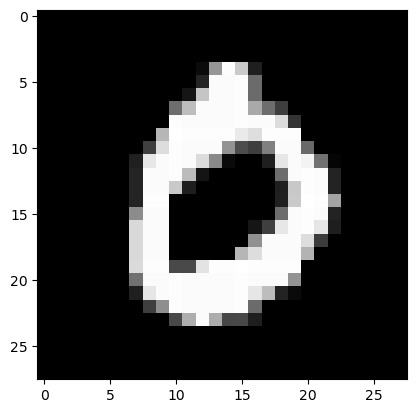

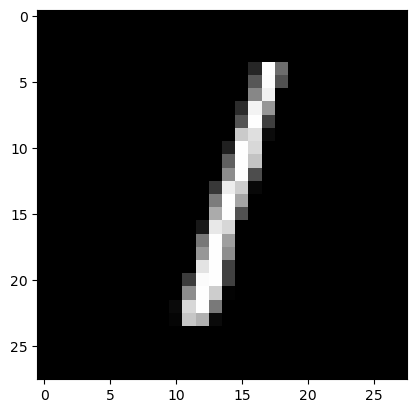

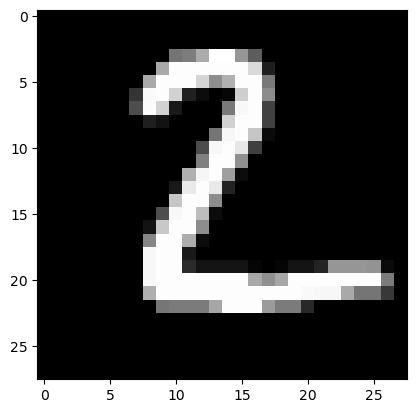

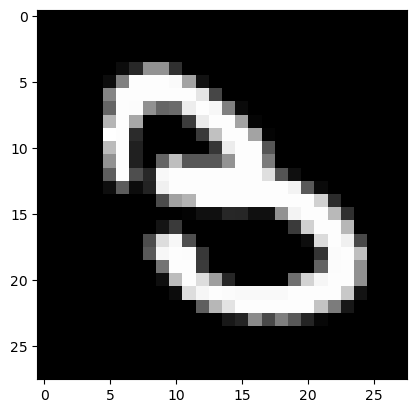

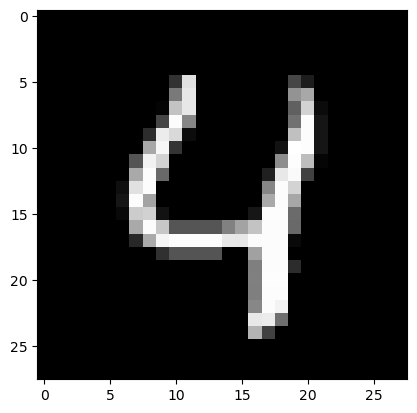

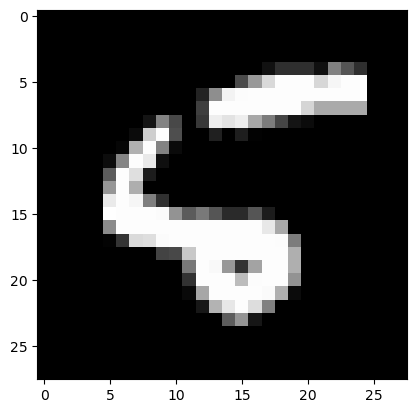

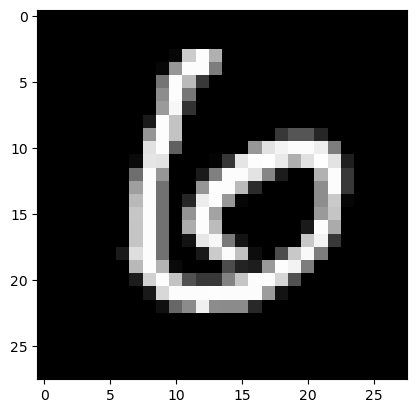

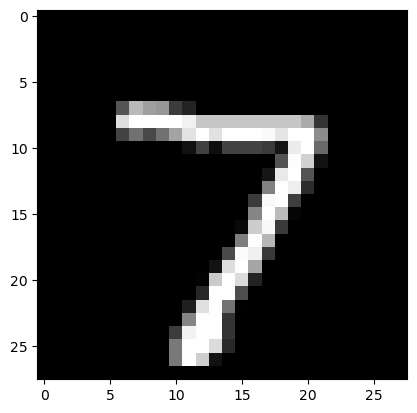

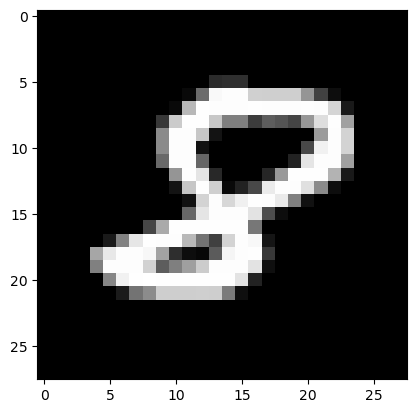

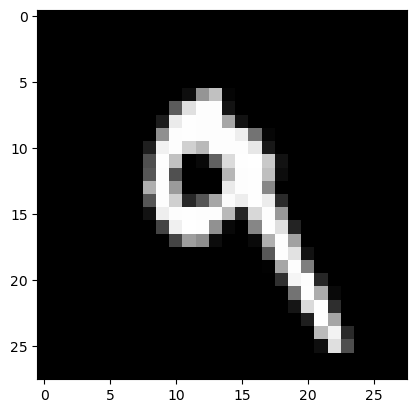

In [13]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

for img in image_set:
    imshow(img)

In [14]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        #self.initialize_parameters()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return F.softmax(x, dim=1)
    
    def initialize_parameters(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.001)  # Initialize weights with normal distribution
                # if module.bias is not None:
                #     nn.init.zeros_(module.bias)





In [15]:
class SquaredHellingerLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, CLIPEx_pred, neural_pred):
       
        neural_pred = F.one_hot(neural_pred, num_classes=10)
        # Calculate the Hellinger distance
        
        sqrt_p = torch.sqrt(CLIPEx_pred)
        sqrt_q = torch.sqrt(neural_pred)
        
        hellinger_dist = torch.sum((sqrt_p - sqrt_q) ** 2, dim=1)
        
        # Return the mean squared Hellinger distance
        return torch.mean(hellinger_dist)/2

class SquaredLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, CLIPEx_pred, neural_pred):
       
        neural_pred = F.one_hot(neural_pred, num_classes=10)
        # Calculate the Hellinger distance
        
        sqrt_p = torch.sqrt(CLIPEx_pred)
        sqrt_q = torch.sqrt(neural_pred)
        
        hellinger_dist = torch.sum((CLIPEx_pred - neural_pred) ** 2, dim=1)
        
        # Return the mean squared Hellinger distance
        return torch.mean(hellinger_dist)/2


class TVDistanceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, CLIPEx_pred, neural_pred):
       
        neural_pred = F.one_hot(neural_pred, num_classes=10)
        # Calculate the Hellinger distance
        
        #sqrt_p = torch.sqrt(CLIPEx_pred)
        #sqrt_q = torch.sqrt(neural_pred)
        
        hellinger_dist = torch.sum(torch.abs(CLIPEx_pred - neural_pred) , dim=1)
        
        # Return the mean squared Hellinger distance
        return torch.mean(hellinger_dist)/2

def Complex_Neural_Training (epochs, lr, model, train_loader, criterion_train,criterion_test, optimizer, test_loader,L2_lambda):
    train_loss_dynamics = []
    test_loss_dynamics = []

    TV_loss_dynamics = []
    #validation_loss_dynamics = []
    accuracy = []

    for epoch in range(epochs):
        training_loss_list = []
        for index, (data, labels) in enumerate(train_loader):
            # Giving data to cuda
            data = data.reshape(data.size(0), -1).to(device=device)
            labels = labels.to(device=device)
            # forward pass
            y_hat = model(data)
            loss = criterion_train(y_hat, labels)
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())/(2*len(labels))
            loss = loss + L2_lambda * l2_norm
            loss.requires_grad_(True)

            #Computing The Gradient On The Mini-Batch Loss
            loss.backward()
            
            #Computing The ADAM Update Using The Above Computed Stochastic Gradient
            optimizer.step()
            optimizer.zero_grad()


        #validation_loss = torch.stack(get_loss(validation_loader, criterion, model)).mean().item()
        training_loss = torch.stack(get_loss(train_loader, criterion_train, model)).mean().item()

        test_loss = torch.stack(get_loss(test_loader, criterion_train, model)).mean().item()
        TV_test_loss = torch.stack(get_loss(test_loader, criterion_test, model)).mean().item()
        #The above computes the empirical and test loss on the whole training and the test data respectively.

        
        #The above computes the empirical and test classification risk on the whole training and the test data respectively.

        train_loss_dynamics.append(training_loss)
        test_loss_dynamics.append(test_loss)
        TV_loss_dynamics.append(TV_test_loss)
        #validation_loss_dynamics.append(validation_loss)

        print (f'Epoch [{epoch+1}/{epochs}]: The training loss is {training_loss:.4f}')

    return train_loss_dynamics, test_loss_dynamics, TV_loss_dynamics


def Neural_only_Training (epochs, lr, model, train_loader, criterion, optimizer,L2_lambda):
    train_loss_dynamics = []
    #test_loss_dynamics = []
    train_accuracy_dynamics = []
    #test_accuracy_dynamics = []
    #validation_loss_dynamics = []
    accuracy = []

    for epoch in range(epochs):
        training_loss_list = []
        for index, (data, labels) in enumerate(train_loader):
            # Giving data to cuda
            data = data.reshape(data.size(0), -1).to(device=device)
            labels = labels.to(device=device)
            # forward pass
            y_hat = model(data)
            loss = criterion(y_hat, labels)
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())/(2*len(labels))
            loss = loss + L2_lambda * l2_norm
            loss.requires_grad_(True)

            #Computing The Gradient On The Mini-Batch Loss
            loss.backward()
            
            #Computing The ADAM Update Using The Above Computed Stochastic Gradient
            optimizer.step()
            optimizer.zero_grad()


        #validation_loss = torch.stack(get_loss(validation_loader, criterion, model)).mean().item()
        training_loss = torch.stack(get_loss(train_loader, criterion, model)).mean().item()
        #test_loss = torch.stack(get_loss(test_loader, criterion, model)).mean().item()
        #The above computes the empirical and test loss on the whole training and the test data respectively.

        train_accuracy_dynamics.append(get_accuracy(train_loader,model))
        #test_accuracy_dynamics.append(get_accuracy(test_loader,model))
        #The above computes the empirical and test classification risk on the whole training and the test data respectively.

        train_loss_dynamics.append(training_loss)
        #test_loss_dynamics.append(test_loss)
        #validation_loss_dynamics.append(validation_loss)

        print (f'Epoch [{epoch+1}/{epochs}]: The training loss is {training_loss:.4f}')

    return train_accuracy_dynamics, train_loss_dynamics

In [16]:
def draw_weight(simple_model,sample_number,standard_deviation,digit):
    Font_Size = 70
    weights = simple_model.state_dict()['linear.weight'].cpu().numpy()
    plt.figure(figsize=(100, 30))
    plt.imshow(weights, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f'Weights of the Linear Classifier (sample number:{sample_number})(standard_deviation:{standard_deviation})(digit:{digit})',fontsize=Font_Size)
    plt.xlabel('Pixels (Flattened 28x28 Image)',fontsize=Font_Size)
    plt.ylabel('Digits (0-9)',fontsize=Font_Size)

# Set x-axis labels
    num_pixels = 28 * 28
    x_ticks = list(range(0, num_pixels, 28))
    x_labels = [str(i*28) for i in range(28)]
    plt.xticks(x_ticks, x_labels,fontsize=Font_Size)

# Set y-axis labels
    y_labels = [str(i) for i in range(10)]
    plt.yticks(list(range(10)), y_labels,fontsize=Font_Size)
    #plt.savefig(f'report/C-LIME/5000_0-'+str(standard_deviation)[2:len(str(standard_deviation))]+f'/weight{digit}')
    plt.show()

def draw_reshape_weight(simple_model,digit, standard_deviation):
    weights = simple_model.state_dict()['linear.weight'].cpu()
    # fig, axes = plt.subplots(2, 5, figsize=(50, 20))
    # for i, ax in enumerate(axes.flat):
    #     weight_image = weights[i, :].reshape(28, 28)
    #     cax = ax.imshow(weight_image, cmap='viridis')
    #     ax.set_title(f'Class {i}')
    #     ax.axis('off')
    fig, axes = plt.subplots(2, 5, figsize=(100, 40))
    for i, ax in enumerate(axes.flat):
        weight_image = weights[i, :].reshape(28, 28)
        sns.heatmap(weight_image, ax=ax,annot=True, fmt=".2f")
        ax.set_title(f'{i}',fontsize=50)
    #plt.savefig(f'report/C-LIME/5000_0-'+str(standard_deviation)[2:len(str(standard_deviation))]+f'/reshape_weight{digit}')
    plt.show()
    
    



In [ ]:

def whole_process(sample_number, sd, img1,digit):
    criterion_train_sq = SquaredLoss()
    criterion_train = SquaredHellingerLoss()
    criterion_test = TVDistanceLoss()
    simple_model = LinearClassifier(input_size, 10).to(device)
    dirs = 'report/C-LIPEx/5000_0-'+str(sd)[2:len(str(sd))]

    if not os.path.exists(dirs):
        os.makedirs(dirs)

    train_sample_number = sample_number
    Train_DL = create_pertubation(img1,train_sample_number,0,sd,o_model)
    test_DL = create_pertubation(img1,10*train_sample_number,0,sd,o_model) #

    if sample_number==5000:
        training_epoch=400
    else:
        training_epoch=250
        
    simple_train_loss, simple_test_loss, TV_test_loss = Complex_Neural_Training(training_epoch, eta, simple_model, 
            Train_DL, criterion_train_sq,criterion_test, torch.optim.Adam(simple_model.parameters(), lr=0.001),test_DL,0.0001)
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    font_size = 20
#axs[0,0].plot(u_train_loss, '-bx')
    axs[0].plot(simple_train_loss)


    axs[0].set_xlabel('epoch',fontsize=font_size)
    axs[0].set_ylabel('loss',fontsize=font_size)
#axs[0].legend([f'{train_sample_number} train samples'])
    axs[0].legend([f'Train loss for {sample_number} samples' ],fontsize=font_size)
    axs[0].set_title('Training Loss vs Epochs (Standard deviation:'+str(sd)+')',fontsize=font_size)
    axs[0].yaxis.grid(True)
    axs[0].text(len(simple_train_loss), 1.1*simple_train_loss[-1], f'{simple_train_loss[-1]:.5f}', ha='center', va='center', color='black', fontsize=font_size)
    axs[0].text(0, 1.1*simple_train_loss[0], f'{simple_train_loss[0]:.4f}', ha='center', va='center', color='black', fontsize=font_size)
# axs[0].text(150, 0.02, f'{simple_train_loss[150]:.4f}', ha='center', va='center', color='black', fontsize=10)
# axs[0].text(200, 0.01, f'{simple_train_loss[200]:.4f}', ha='center', va='center', color='black', fontsize=10)
# axs[0].text(250, 0.01, f'{simple_train_loss[250]:.4f}', ha='center', va='center', color='black', fontsize=10)
    axs[0].set_ylim(0.00001,1) 
    axs[0].set_yscale("log",base=10)

#axs[0].text(800, 0.1, f'{simple_train_loss[800]:.4f}', ha='center', va='center', color='black', fontsize=10)


#axs[0,1].plot(u_test_loss, '-bx')
    axs[1].plot(simple_test_loss, color='red')
    axs[1].plot(TV_test_loss, color='green')
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('loss')
    axs[1].legend([f'Hellinger test loss for {10*sample_number} samples',f'TV test loss {10*sample_number} samples'],fontsize=font_size)
    axs[1].set_title('Test Loss vs Epochs',fontsize=font_size)
    axs[1].yaxis.grid(True)
    axs[1].set_ylim(0.00001,1) 
    axs[1].set_yscale("log",base=10)
#axs[1].text(50len(simple_test_loss)0, 0.1, f'{simple_test_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=10)
#axs[1].text(0, 1.1, f'{simple_test_loss[0]:.4f}', ha='center', va='center', color='black', fontsize=10)
    axs[1].text(len(simple_test_loss), 1.1*simple_test_loss[-1], f'{simple_test_loss[-1]:.5f}', ha='center', va='center', color='black', fontsize=font_size)
    axs[1].text(len(TV_test_loss), 1.5*TV_test_loss[-1], f'{TV_test_loss[-1]:.5f}', ha='center', va='center', color='black', fontsize=font_size)
#axs[1].text(150, 0.02, f'{simple_test_loss[150]:.4f}', ha='center', va='center', color='black', fontsize=10)
#axs[1].text(200, 0.01, f'{simple_test_loss[200]:.4f}', ha='center', va='center', color='black', fontsize=10)
#axs[1].text(250, 0.01, f'{simple_test_loss[250]:.4f}', ha='center', va='center', color='black', fontsize=10)
    plt.tight_layout()
    #plt.savefig(f'report/C-LIME/5000_0-'+str(sd)[2:len(str(sd))]+f'/loss{digit}')
    draw_weight(simple_model,sample_number,sd,digit)
    draw_reshape_weight(simple_model,digit,sd)


sn = [5000]
sd = [0.001]
for i in sn:
    for j in sd:
        whole_process(i,j,image_set[4],4)
        # digit=0
        
        # for img in image_set:
        #     whole_process(i,j,img,digit)
        #     digit =digit+1
           


In [28]:
img1=image_set[0]
sd=0.001
criterion_train = SquaredLoss()
criterion_train2 = SquaredHellingerLoss()
criterion_test = TVDistanceLoss()
t1 = time()
train_sample_number = 5000
training_epoch = 400
simple_model = LinearClassifier(input_size, 10).to(device)
Train_DL = create_pertubation(img1,train_sample_number,0,sd,o_model)
test_DL = create_pertubation(img1,10*train_sample_number,0,sd,o_model) #
t2 = time()
# train_accuracy_dynamics, train_loss_dynamics = Neural_Training(training_epoch, eta, simple_model, 
#             Train_DL, criterion_train2, torch.optim.Adam(simple_model.parameters(), lr=0.001,weight_decay=0.0001))
simple_train_loss, simple_test_loss, TV_test_loss = Complex_Neural_Training(training_epoch, eta, simple_model, 
            Train_DL, criterion_train2,criterion_test, torch.optim.Adam(simple_model.parameters(), lr=0.001),test_DL,0.01)
t3 = time()
print('Generating time:'+str(t2-t1),'Training time:',str(t3-t2))

Epoch [1/400]: The training loss is 0.6566
Epoch [2/400]: The training loss is 0.6283
Epoch [3/400]: The training loss is 0.5986
Epoch [4/400]: The training loss is 0.5672
Epoch [5/400]: The training loss is 0.5367
Epoch [6/400]: The training loss is 0.5061
Epoch [7/400]: The training loss is 0.4785
Epoch [8/400]: The training loss is 0.4504
Epoch [9/400]: The training loss is 0.4239
Epoch [10/400]: The training loss is 0.4017
Epoch [11/400]: The training loss is 0.3816
Epoch [12/400]: The training loss is 0.3617
Epoch [13/400]: The training loss is 0.3446
Epoch [14/400]: The training loss is 0.3300
Epoch [15/400]: The training loss is 0.3132
Epoch [16/400]: The training loss is 0.3007
Epoch [17/400]: The training loss is 0.2870
Epoch [18/400]: The training loss is 0.2761
Epoch [19/400]: The training loss is 0.2639
Epoch [20/400]: The training loss is 0.2555
Epoch [21/400]: The training loss is 0.2442
Epoch [22/400]: The training loss is 0.2338
Epoch [23/400]: The training loss is 0.22

In [33]:
#torch.save(simple_model, 'saved_model/0sample5000_01.pth')

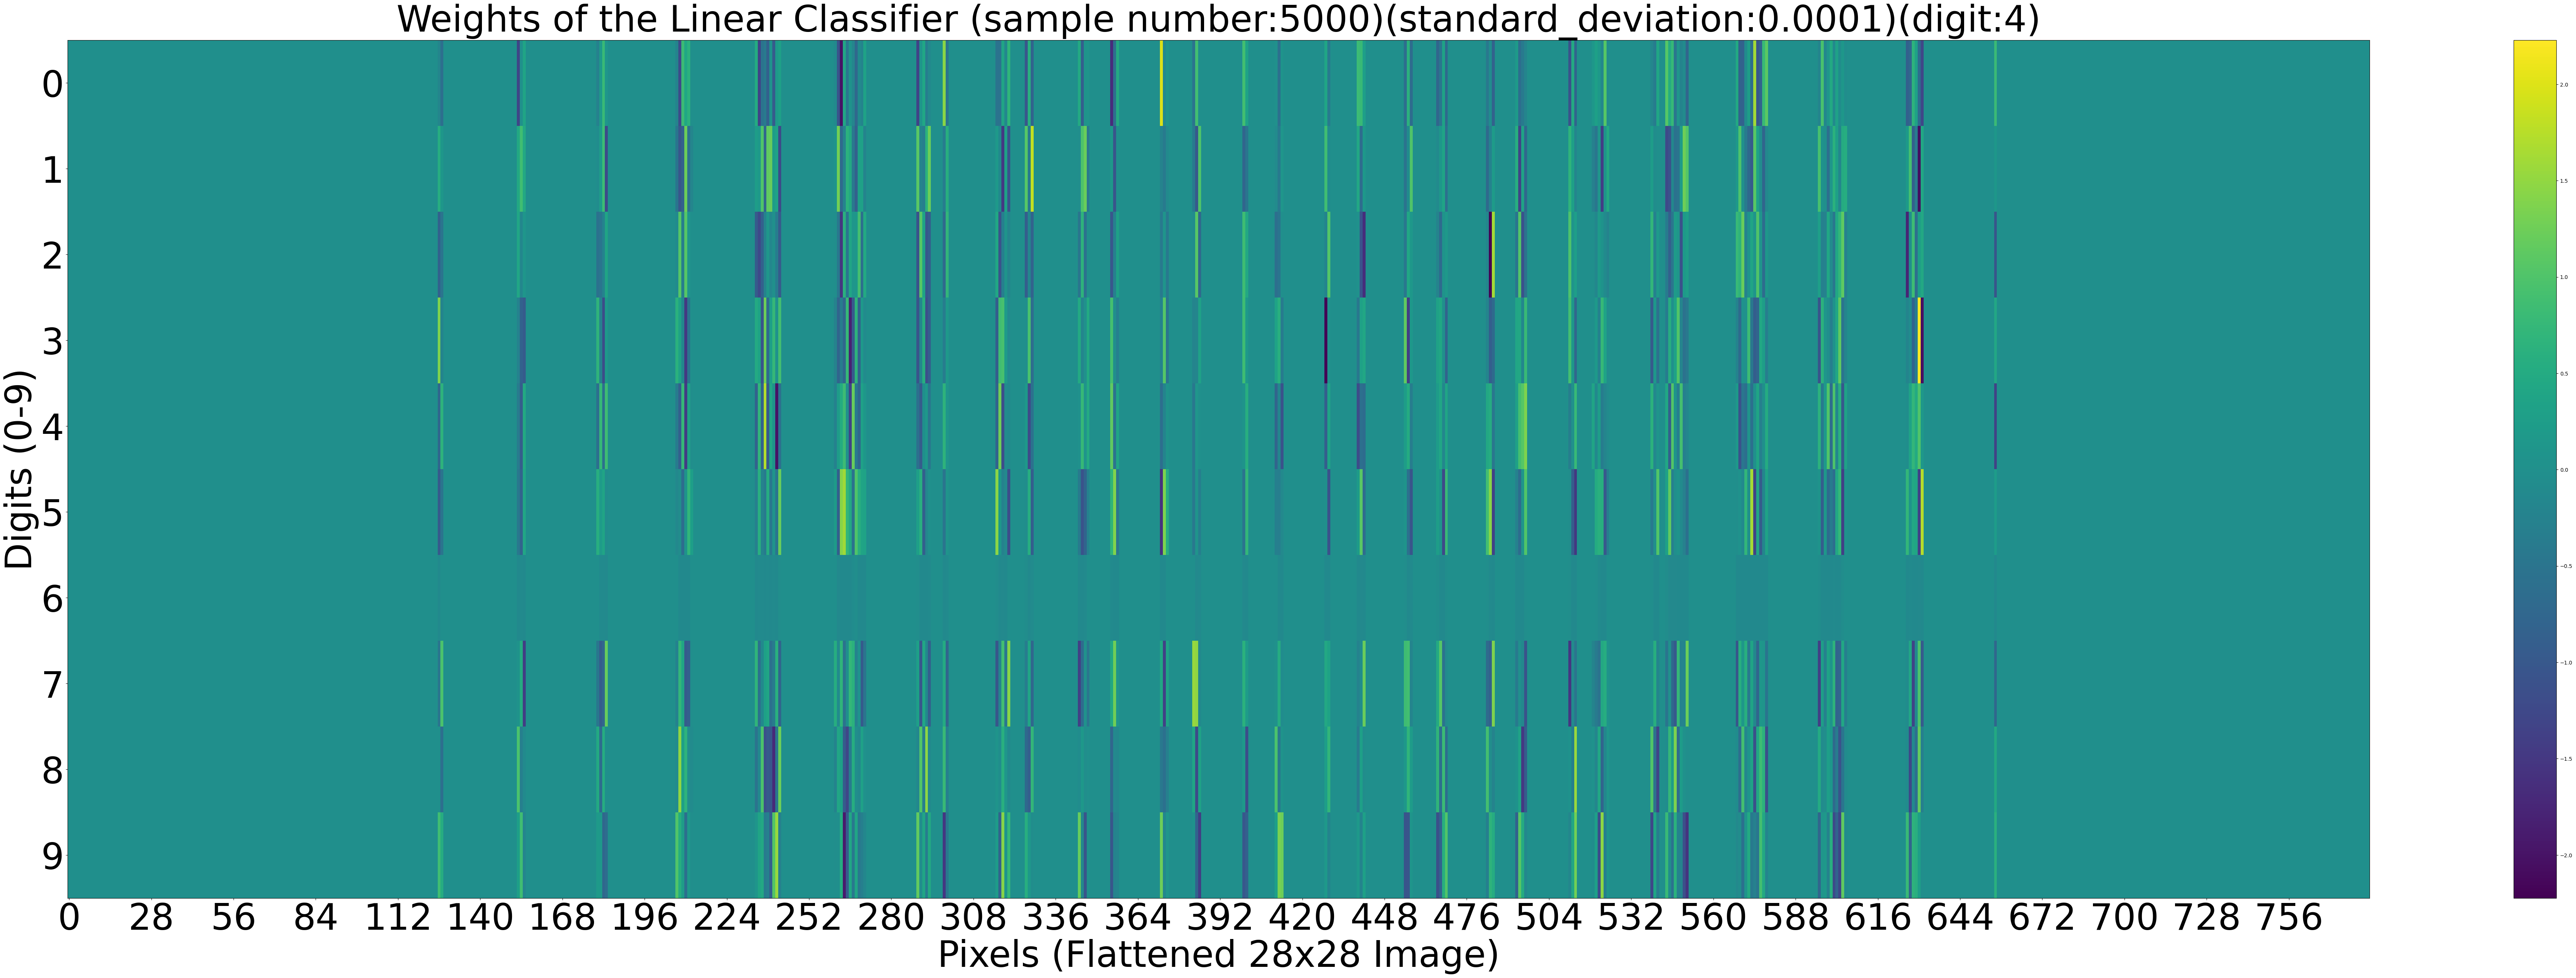

In [76]:
#draw_model = torch.load('saved_model/0sample5000_01.pth')
draw_weight(simple_model,5000,0.0001,4)

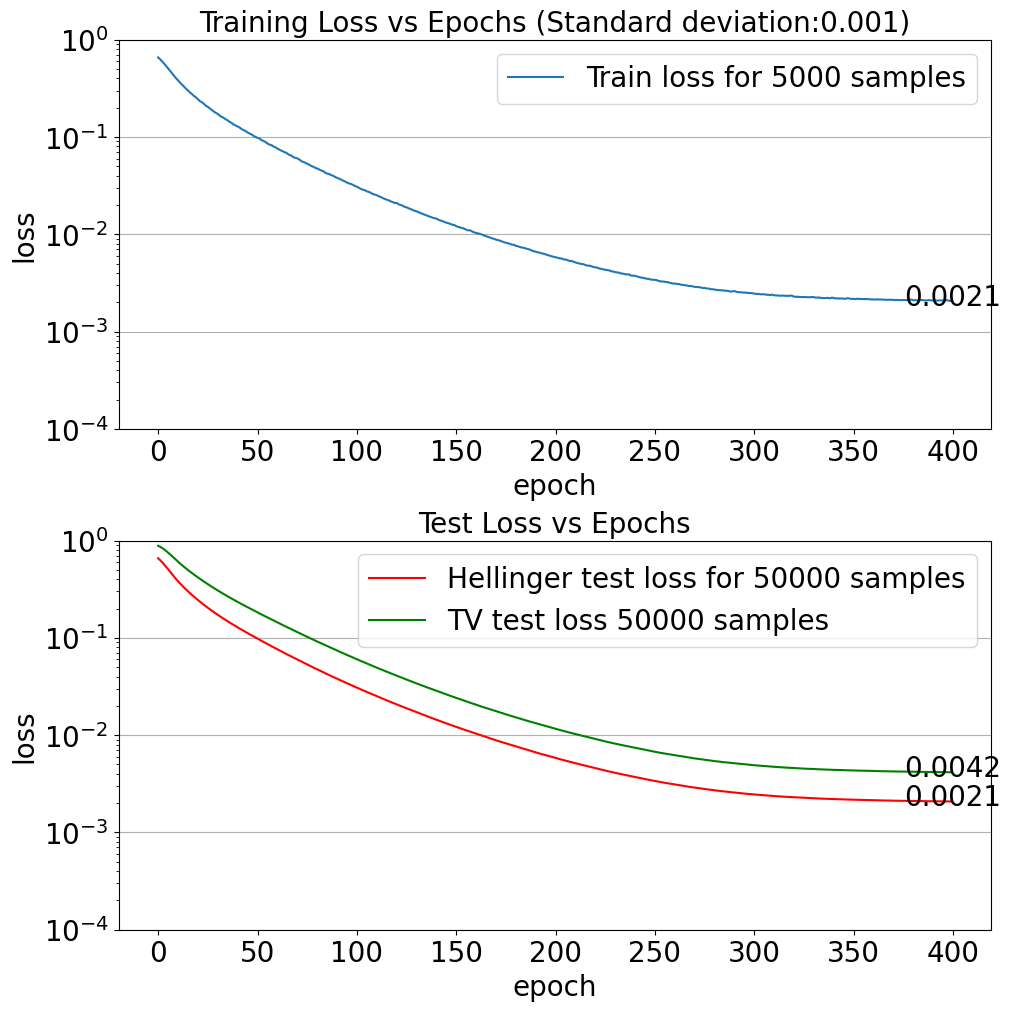

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10),constrained_layout=True)
#axs[0].plot(train_accuracy_dynamics)
axs[0].plot(simple_train_loss)
axs[0].set_xlabel('epoch',fontsize=20)
axs[0].set_ylabel('loss',fontsize=20)
axs[0].tick_params(axis='both',labelsize=20)
#axs[0].legend([f'{train_sample_number} train samples'])
axs[0].legend([f'Train loss for {train_sample_number} samples' ],fontsize=20)
axs[0].set_title('Training Loss vs Epochs (Standard deviation:'+str(sd)+')',fontsize=20)
axs[0].text(len(simple_train_loss), 1.1*simple_train_loss[-1], f'{simple_train_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
axs[0].yaxis.grid(True)
axs[0].set_ylim(0.0001,1) 
axs[0].set_yscale("log",base=10)

#axs[1].plot(train_loss_dynamics, color='red')
axs[1].plot(simple_test_loss, color='red')
axs[1].plot(TV_test_loss, color='green')
axs[1].set_xlabel('epoch',fontsize=20)
axs[1].set_ylabel('loss',fontsize=20)
axs[1].tick_params(axis='both',labelsize=20)
axs[1].legend([f'Hellinger test loss for {10*train_sample_number} samples',f'TV test loss {10*train_sample_number} samples'],fontsize=20)
axs[1].set_title('Test Loss vs Epochs',fontsize=20)
axs[1].text(len(simple_test_loss), 1.1*simple_test_loss[-1], f'{simple_test_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
axs[1].text(len(TV_test_loss), 1.1*TV_test_loss[-1], f'{TV_test_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
#axs[1].text(400, 1.1*train_loss_dynamics[399], f'{train_loss_dynamics[399]:.4f}', ha='center', va='center', color='black', fontsize=10)
#axs[1].text(351, 1.1*simple_test_loss[350], f'{simple_test_loss[350]:.5f}', ha='center', va='center', color='black', fontsize=20)

axs[1].yaxis.grid(True)
axs[1].set_ylim(0.0001,1) 
axs[1].set_yscale("log",base=10)

### different standard deviation, sample number and weight decay

In [ ]:
sample_number = [100,500,1000,5000,10000]
standard_deviation = [0.0001,0.001,0.005,0.01,0.05,0.1]
#weight_decay= [0.0001,0.001,0.005,0.01,0.05]#,
img1= image_set[4]
for sd in standard_deviation:
    train_loss=[]
    for sn in sample_number:
        criterion_train = SquaredHellingerLoss()
        Train_DL = create_pertubation(img1,sn,0,sd,o_model)
        model = LinearClassifier(input_size, 10).to(device)
        train_accuracy_dynamics, train_loss_dynamics = Neural_only_Training (300, 0.001, model, Train_DL, criterion_train, torch.optim.Adam(model.parameters(), lr=0.001),0.0001)
        train_loss.append(train_loss_dynamics)
    
    fig = plt.figure(figsize=(10,10))
    for i in train_loss:
        plt.plot(i)
    plt.legend([str(i)+' '+'samples' for i in sample_number],fontsize=25)
    plt.xlabel('epoch',fontsize=25)
    plt.ylabel('Training loss',fontsize=25)
    
    plt.grid(True)
    plt.ylim(0.00001,1) 
    plt.yscale("log",base=10)

    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.title(f'Training loss vs epoch (σ={sd})',fontsize=25)
    plt.tight_layout()
    

In [ ]:
sample_number = [100,500,1000,5000,10000]
standard_deviation = [0.0001,0.005,0.001,0.05,0.01]
weight_decay= [0.0001,0.001,0.005,0.01,0.05]#,
img1= image_set[4]
for wd in weight_decay:
    train_loss=[]
    for sn in sample_number:
        criterion_train = SquaredHellingerLoss()
        Train_DL = create_pertubation(img1,sn,0,0.001,o_model)
        model = LinearClassifier(input_size, 10).to(device)
        train_accuracy_dynamics, train_loss_dynamics = Neural_only_Training (300, 0.001, model, Train_DL, criterion_train, torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=wd),0)
        train_loss.append(train_loss_dynamics)
    
    fig = plt.figure(figsize=(10,10))
    for i in train_loss:
        plt.plot(i)
    plt.legend([str(i)+' '+'samples' for i in sample_number],fontsize=25)
    plt.xlabel('epoch',fontsize=25)
    plt.ylabel('Training loss',fontsize=25)
    
    plt.grid(True)
    plt.ylim(0.00001,1) 
    plt.yscale("log",base=10)

    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.title(f'Training loss vs epoch (Weight decay={wd})',fontsize=25)
    plt.tight_layout()
    

In [17]:
sample_number = [100,500,1000,5000,10000]
L2_regularzation = [0.0001,0.005,0.001,0.05,0.01]
weight_decay= [0.0001,0.001,0.005,0.01,0.05]#,
img1= image_set[4]
for l2 in L2_regularzation:
    train_loss=[]
    for sn in sample_number:
        criterion_train = SquaredHellingerLoss()
        Train_DL = create_pertubation(img1,sn,0,0.001,o_model)
        model = LinearClassifier(input_size, 10).to(device)
        train_accuracy_dynamics, train_loss_dynamics = Neural_only_Training (300, 0.001, model, Train_DL, criterion_train, torch.optim.Adam(model.parameters(), lr=0.001),l2)
        train_loss.append(train_loss_dynamics)
    
    fig = plt.figure(figsize=(10,10))
    for i in train_loss:
        plt.plot(i)
    plt.legend([str(i)+' '+'samples' for i in sample_number],fontsize=25)
    plt.xlabel('epoch',fontsize=30)
    plt.ylabel('Training loss',fontsize=30)

    plt.grid(True)
    plt.ylim(0.00001,1) 
    plt.yscale("log",base=10)

    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.title(f'Training loss vs epoch (λ={l2})',fontsize=30)
    plt.tight_layout()
    

KeyboardInterrupt: 

In [37]:
#sample_number = [100,500,1000,5000,10000]
L2_regularzation = [0.0001,0.001,0.005,0.01,0.05]#
weight_decay= [0.0001,0.001,0.005,0.01,0.05]#,
img1= image_set[4]
train_loss=[]
Htest_loss=[]
TV_loss=[]
for l2 in L2_regularzation:
    criterion_train = SquaredHellingerLoss()
    criterion_test = TVDistanceLoss()
    Train_DL = create_pertubation(img1,5000,0,0.001,o_model)
    Test_DL = create_pertubation(img1,10*5000,0,0.001,o_model)
    model = LinearClassifier(input_size, 10).to(device)
    simple_train_loss, simple_test_loss, TV_test_loss = Complex_Neural_Training (400, 0.001, model, Train_DL, criterion_train,criterion_test, torch.optim.Adam(model.parameters(), lr=0.001),Test_DL,l2)
    train_loss.append(simple_train_loss)
    Htest_loss.append(simple_test_loss)
    TV_loss.append(TV_test_loss)


Epoch [1/400]: The training loss is 0.6629
Epoch [2/400]: The training loss is 0.6458
Epoch [3/400]: The training loss is 0.6277
Epoch [4/400]: The training loss is 0.6094
Epoch [5/400]: The training loss is 0.5895
Epoch [6/400]: The training loss is 0.5707
Epoch [7/400]: The training loss is 0.5497
Epoch [8/400]: The training loss is 0.5295
Epoch [9/400]: The training loss is 0.5083
Epoch [10/400]: The training loss is 0.4879
Epoch [11/400]: The training loss is 0.4685
Epoch [12/400]: The training loss is 0.4493
Epoch [13/400]: The training loss is 0.4315
Epoch [14/400]: The training loss is 0.4134
Epoch [15/400]: The training loss is 0.3968
Epoch [16/400]: The training loss is 0.3819
Epoch [17/400]: The training loss is 0.3656
Epoch [18/400]: The training loss is 0.3526
Epoch [19/400]: The training loss is 0.3396
Epoch [20/400]: The training loss is 0.3282
Epoch [21/400]: The training loss is 0.3143
Epoch [22/400]: The training loss is 0.3059
Epoch [23/400]: The training loss is 0.29

In [33]:
def draw_l2(train_loss,Htest_loss,TV_loss,lambda_set):
    fig, axs = plt.subplots(3, 1, figsize=(10, 10),constrained_layout=True)
    for i in train_loss:
        axs[0].plot(i)
    axs[0].set_xlabel('epoch',fontsize=20)
    axs[0].set_ylabel('loss',fontsize=20)
    axs[0].tick_params(axis='both',labelsize=20)
#axs[0].legend([f'{train_sample_number} train samples'])
    axs[0].legend(['λ='+str(i) for i in lambda_set],fontsize=20)
    axs[0].set_title('Training Loss vs Epochs ',fontsize=20)
    #axs[0].text(len(train_loss), 1.1*train_loss[-1], f'{train_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
    axs[0].yaxis.grid(True)
    axs[0].set_ylim(0.0001,1) 
    axs[0].set_yscale("log",base=10)

#axs[1].plot(train_loss_dynamics, color='red')
    for i in Htest_loss:
        axs[1].plot(i)
    #axs[1].plot(TV_test_loss, color='green')
    axs[1].set_xlabel('epoch',fontsize=20)
    axs[1].set_ylabel('loss',fontsize=20)
    axs[1].tick_params(axis='both',labelsize=20)
    axs[1].legend(['λ='+str(i) for i in lambda_set],fontsize=20)
    axs[1].set_title('Hellinger Test Loss vs Epochs',fontsize=20)
    #axs[1].text(len(Htest_loss), 1.1*Htest_loss[-1], f'{Htest_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
    #axs[1].text(len(TV_test_loss), 1.1*TV_test_loss[-1], f'{TV_test_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
#axs[1].text(400, 1.1*train_loss_dynamics[399], f'{train_loss_dynamics[399]:.4f}', ha='center', va='center', color='black', fontsize=10)
#axs[1].text(351, 1.1*simple_test_loss[350], f'{simple_test_loss[350]:.5f}', ha='center', va='center', color='black', fontsize=20)
    axs[1].yaxis.grid(True)
    axs[1].set_ylim(0.0001,1) 
    axs[1].set_yscale("log",base=10)

    #axs[2].plot(Htest_loss, color='red')
    for i in TV_loss:
        axs[2].plot(i)
    axs[2].set_xlabel('epoch',fontsize=20)
    axs[2].set_ylabel('loss',fontsize=20)
    axs[2].tick_params(axis='both',labelsize=20)
    axs[2].legend(['λ='+str(i) for i in lambda_set],fontsize=20)
    axs[2].set_title('TV Test Loss vs Epochs',fontsize=20)
    #axs[2].text(len(Htest_loss), 1.1*Htest_loss[-1], f'{Htest_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
    #axs[2].text(len(TV_loss), 1.1*TV_loss[-1], f'{TV_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
    axs[2].yaxis.grid(True)
    axs[2].set_ylim(0.0001,1) 
    axs[2].set_yscale("log",base=10)

In [40]:
def exchange(train_loss,Htest_loss,TV_loss):
    t_l = train_loss.copy()
    H_l = Htest_loss.copy()
    T_l = TV_loss.copy()
    tempt = t_l[1]
    t_l[1]=t_l[2]
    t_l[2]=tempt
    tempt = t_l[3]
    t_l[3]=t_l[4]
    t_l[4]=tempt

    tempt = H_l[1]
    H_l[1]=H_l[2]
    H_l[2]=tempt
    tempt = H_l[3]
    H_l[3]=H_l[4]
    H_l[4]=tempt

    tempt = T_l[1]
    T_l[1]=T_l[2]
    T_l[2]=tempt
    tempt = T_l[3]
    T_l[3]=T_l[4]
    T_l[4]=tempt

    return t_l,H_l,T_l

t_loss,H_loss,T_loss = exchange(train_loss,Htest_loss,TV_loss)



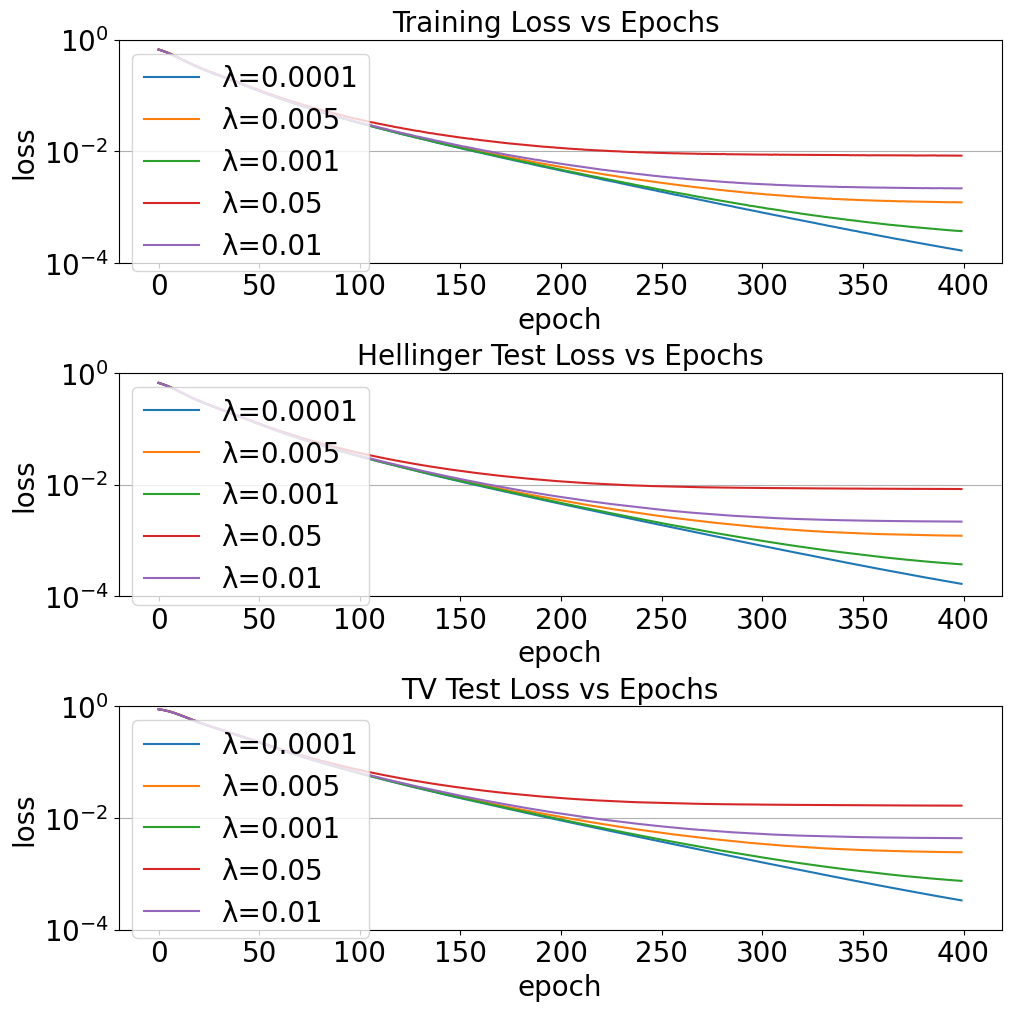

In [38]:
draw_l2(train_loss,Htest_loss,TV_loss,L2_regularzation)


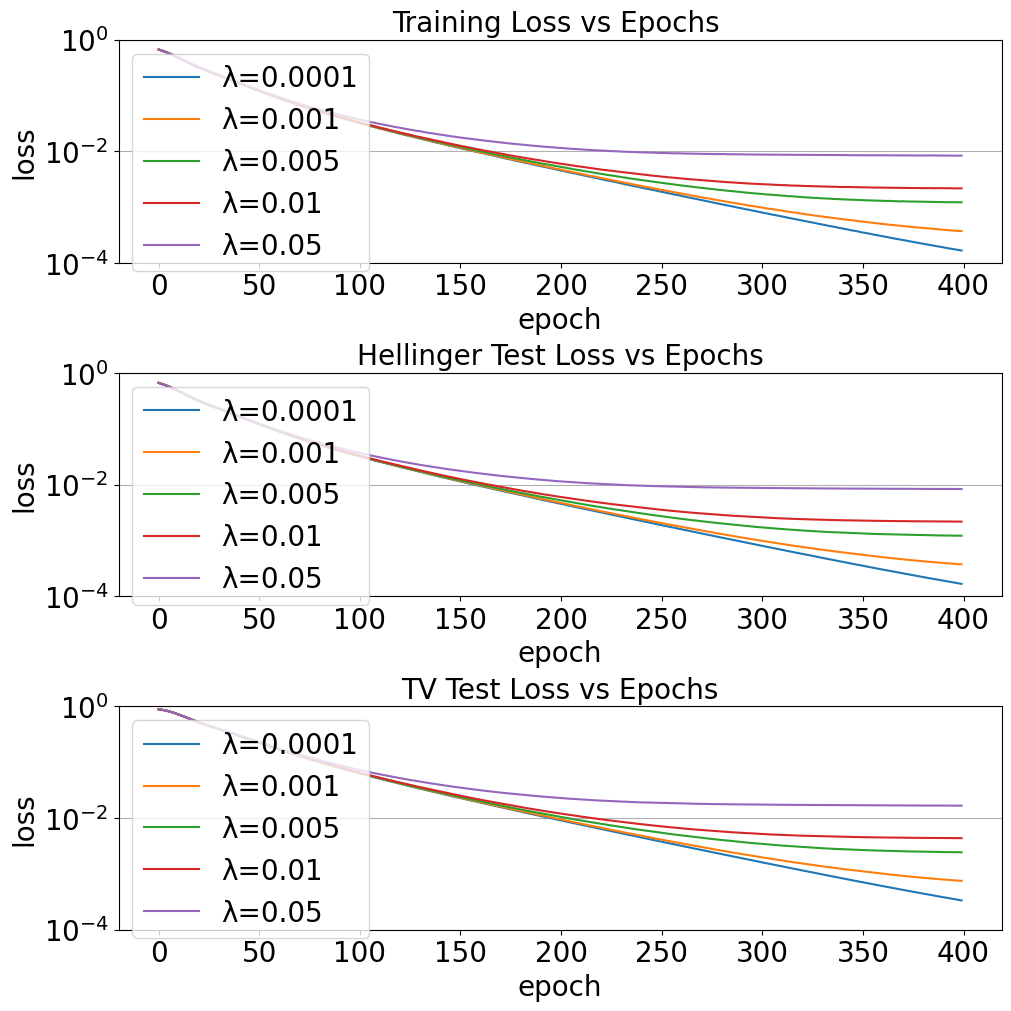

In [41]:
draw_l2(t_loss,H_loss,T_loss,[0.0001,0.001,0.005,0.01,0.05])


### Show the loss and accuarcy of the explainable model

In [26]:
weights = simple_model.state_dict()['linear.weight'].cpu().clone()
print("original:",weights)
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        if weights[i,j]<0:
            weights[i,j]=0
print("new:",weights)

original: tensor([[ 6.5444e-40, -1.0007e-39,  5.6684e-40,  ..., -1.0044e-39,
          7.0535e-40, -2.7390e-39],
        [-3.0050e-39,  6.4913e-40,  2.6618e-39,  ..., -7.0192e-40,
          6.8803e-40,  1.0348e-39],
        [-1.0089e-39, -3.0958e-39, -1.1204e-39,  ...,  2.7420e-39,
         -2.7397e-39, -7.6539e-41],
        ...,
        [-4.5967e-40, -3.8163e-40, -9.9265e-40,  ...,  7.3092e-40,
         -3.0378e-39,  1.6249e-39],
        [-7.4842e-40,  1.1224e-39, -3.1093e-39,  ..., -7.3723e-40,
         -2.6404e-39, -2.7113e-39],
        [-6.0148e-40,  3.1355e-39, -2.7377e-39,  ..., -1.1097e-39,
          4.4070e-40,  5.5912e-40]])
new: tensor([[6.5444e-40, 0.0000e+00, 5.6684e-40,  ..., 0.0000e+00, 7.0535e-40,
         0.0000e+00],
        [0.0000e+00, 6.4913e-40, 2.6618e-39,  ..., 0.0000e+00, 6.8803e-40,
         1.0348e-39],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.7420e-39, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ...

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img1=image_set[4]
sd=1
criterion_train = SquaredLoss()
criterion_train2 = SquaredHellingerLoss()
criterion_test = TVDistanceLoss()
t1 = time()
train_sample_number = 5000
training_epoch = 400
simple_model = LinearClassifier(input_size, 10).to(device)
Train_DL = create_pertubation(img1,train_sample_number,0,sd,o_model)
test_DL = create_pertubation(img1,10,0,sd,o_model) #
t2 = time()
# train_accuracy_dynamics, train_loss_dynamics = Neural_Training(training_epoch, eta, simple_model, 
#             Train_DL, criterion_train2, torch.optim.Adam(simple_model.parameters(), lr=0.001,weight_decay=0.0001))
simple_train_loss, simple_test_loss, TV_test_loss = Complex_Neural_Training(training_epoch, 0.001, simple_model, 
            Train_DL, criterion_train,criterion_test, torch.optim.Adam(simple_model.parameters(), lr=0.001),test_DL,0.0001)
t3 = time()
print('Generating time:'+str(t2-t1),'Training time:',str(t3-t2))

Epoch [1/400]: The training loss is 0.3937
Epoch [2/400]: The training loss is 0.3668
Epoch [3/400]: The training loss is 0.3429
Epoch [4/400]: The training loss is 0.3234
Epoch [5/400]: The training loss is 0.3002
Epoch [6/400]: The training loss is 0.2827
Epoch [7/400]: The training loss is 0.2654
Epoch [8/400]: The training loss is 0.2480
Epoch [9/400]: The training loss is 0.2352
Epoch [10/400]: The training loss is 0.2217
Epoch [11/400]: The training loss is 0.2119
Epoch [12/400]: The training loss is 0.2024
Epoch [13/400]: The training loss is 0.1918
Epoch [14/400]: The training loss is 0.1841
Epoch [15/400]: The training loss is 0.1795
Epoch [16/400]: The training loss is 0.1709
Epoch [17/400]: The training loss is 0.1672
Epoch [18/400]: The training loss is 0.1590
Epoch [19/400]: The training loss is 0.1556
Epoch [20/400]: The training loss is 0.1485
Epoch [21/400]: The training loss is 0.1455
Epoch [22/400]: The training loss is 0.1416
Epoch [23/400]: The training loss is 0.13

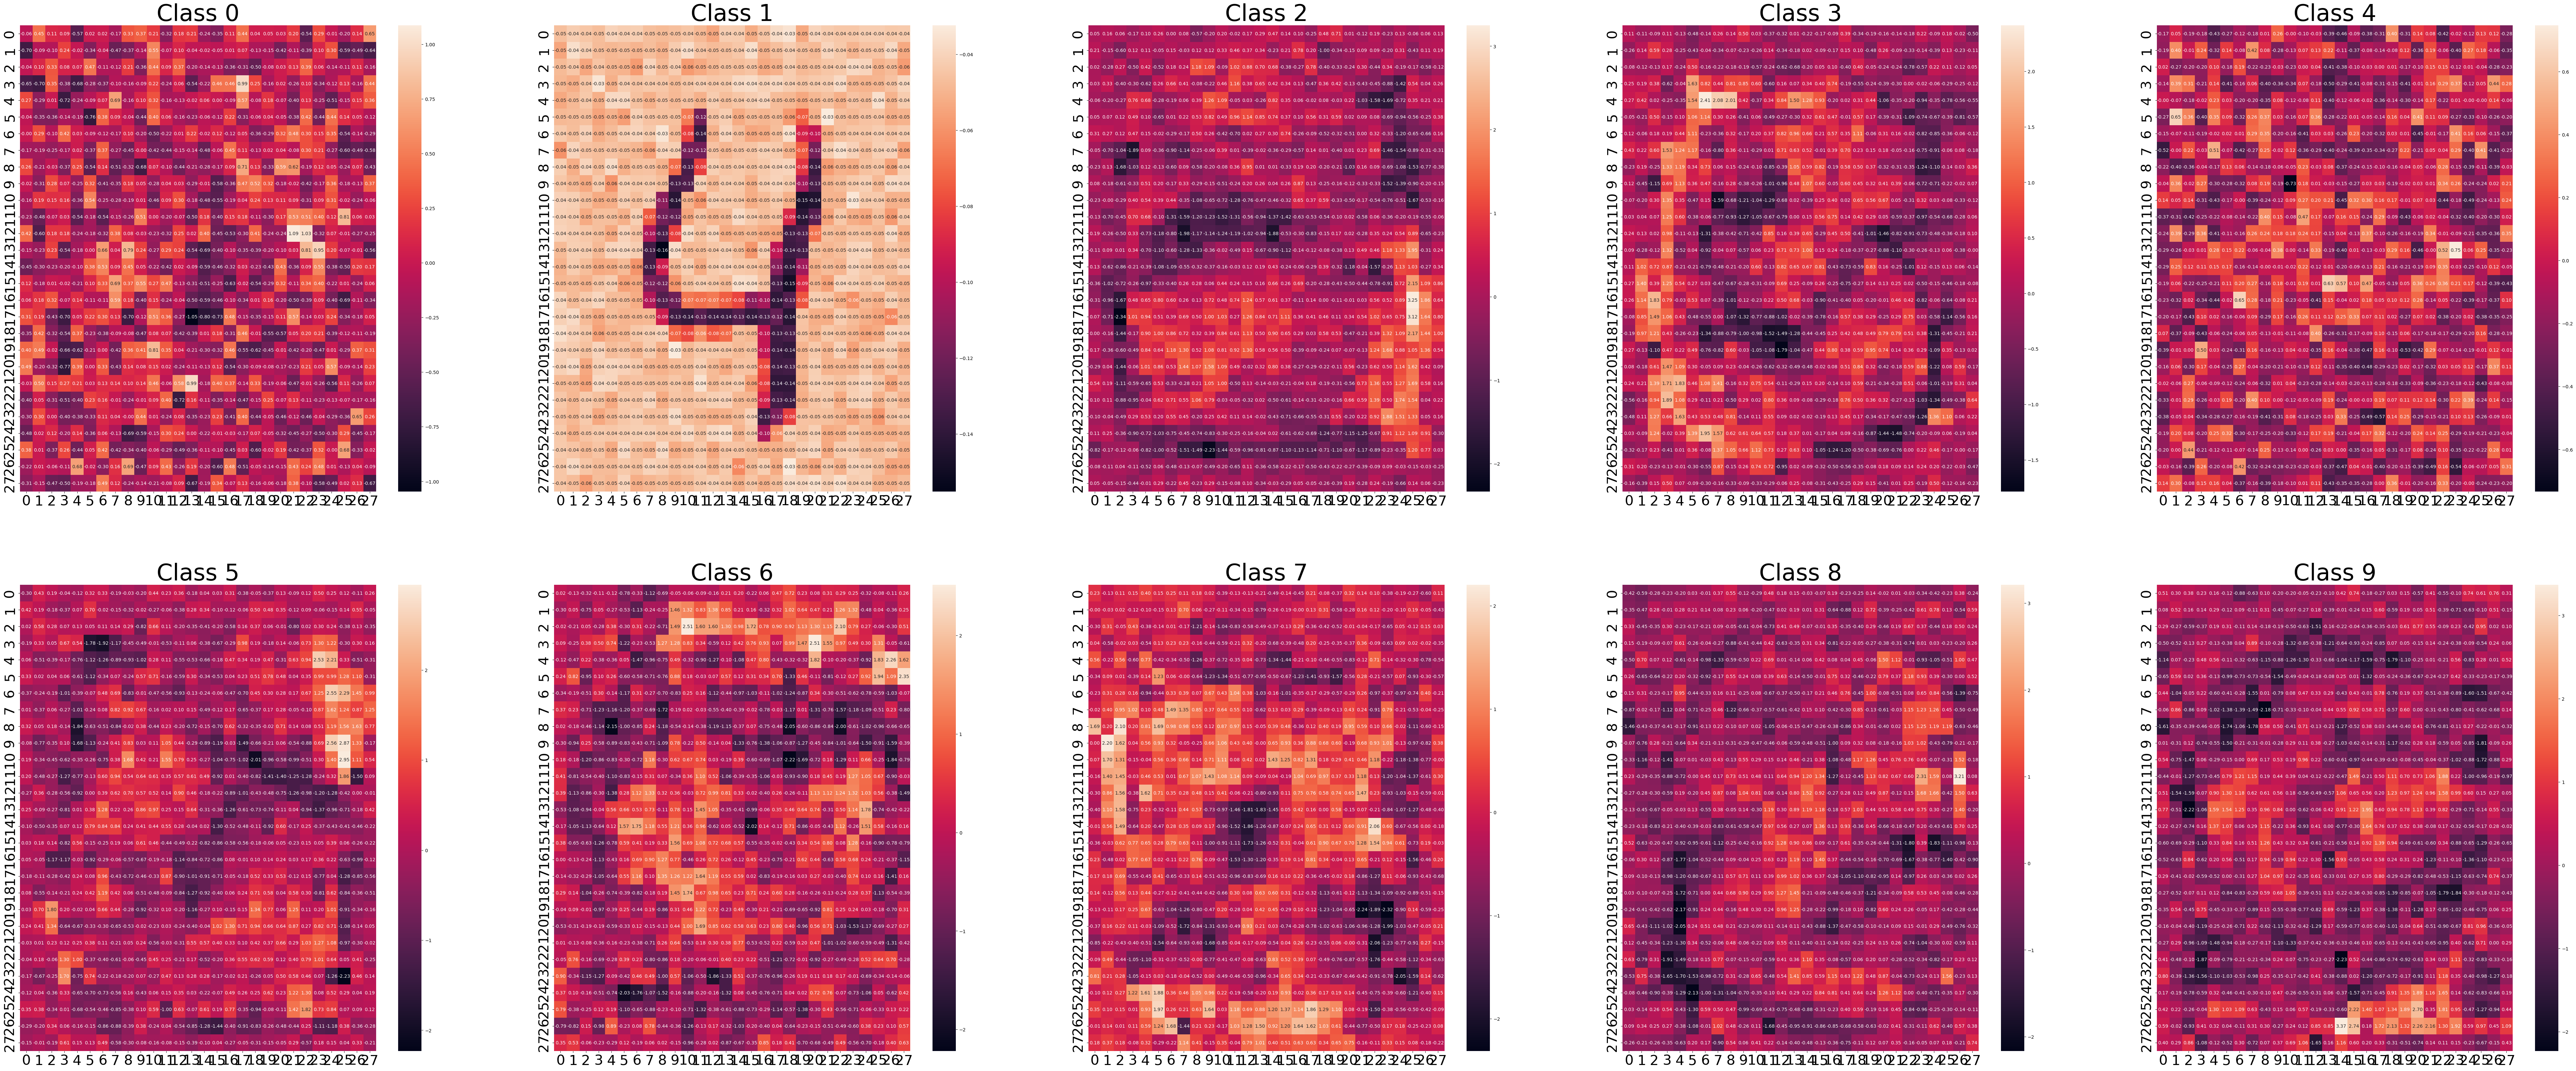

In [20]:
weights = simple_model.state_dict()['linear.weight'].cpu()

fig, axes = plt.subplots(2, 5, figsize=(100, 40))
for i, ax in enumerate(axes.flat):
    weight_image = weights[i, :].reshape(28, 28)
    sns.heatmap(weight_image, ax=ax,annot=True, fmt=".2f")
    ax.set_title(f'Class {i}',fontsize=50)
    ax.tick_params(axis='both',labelsize=30)

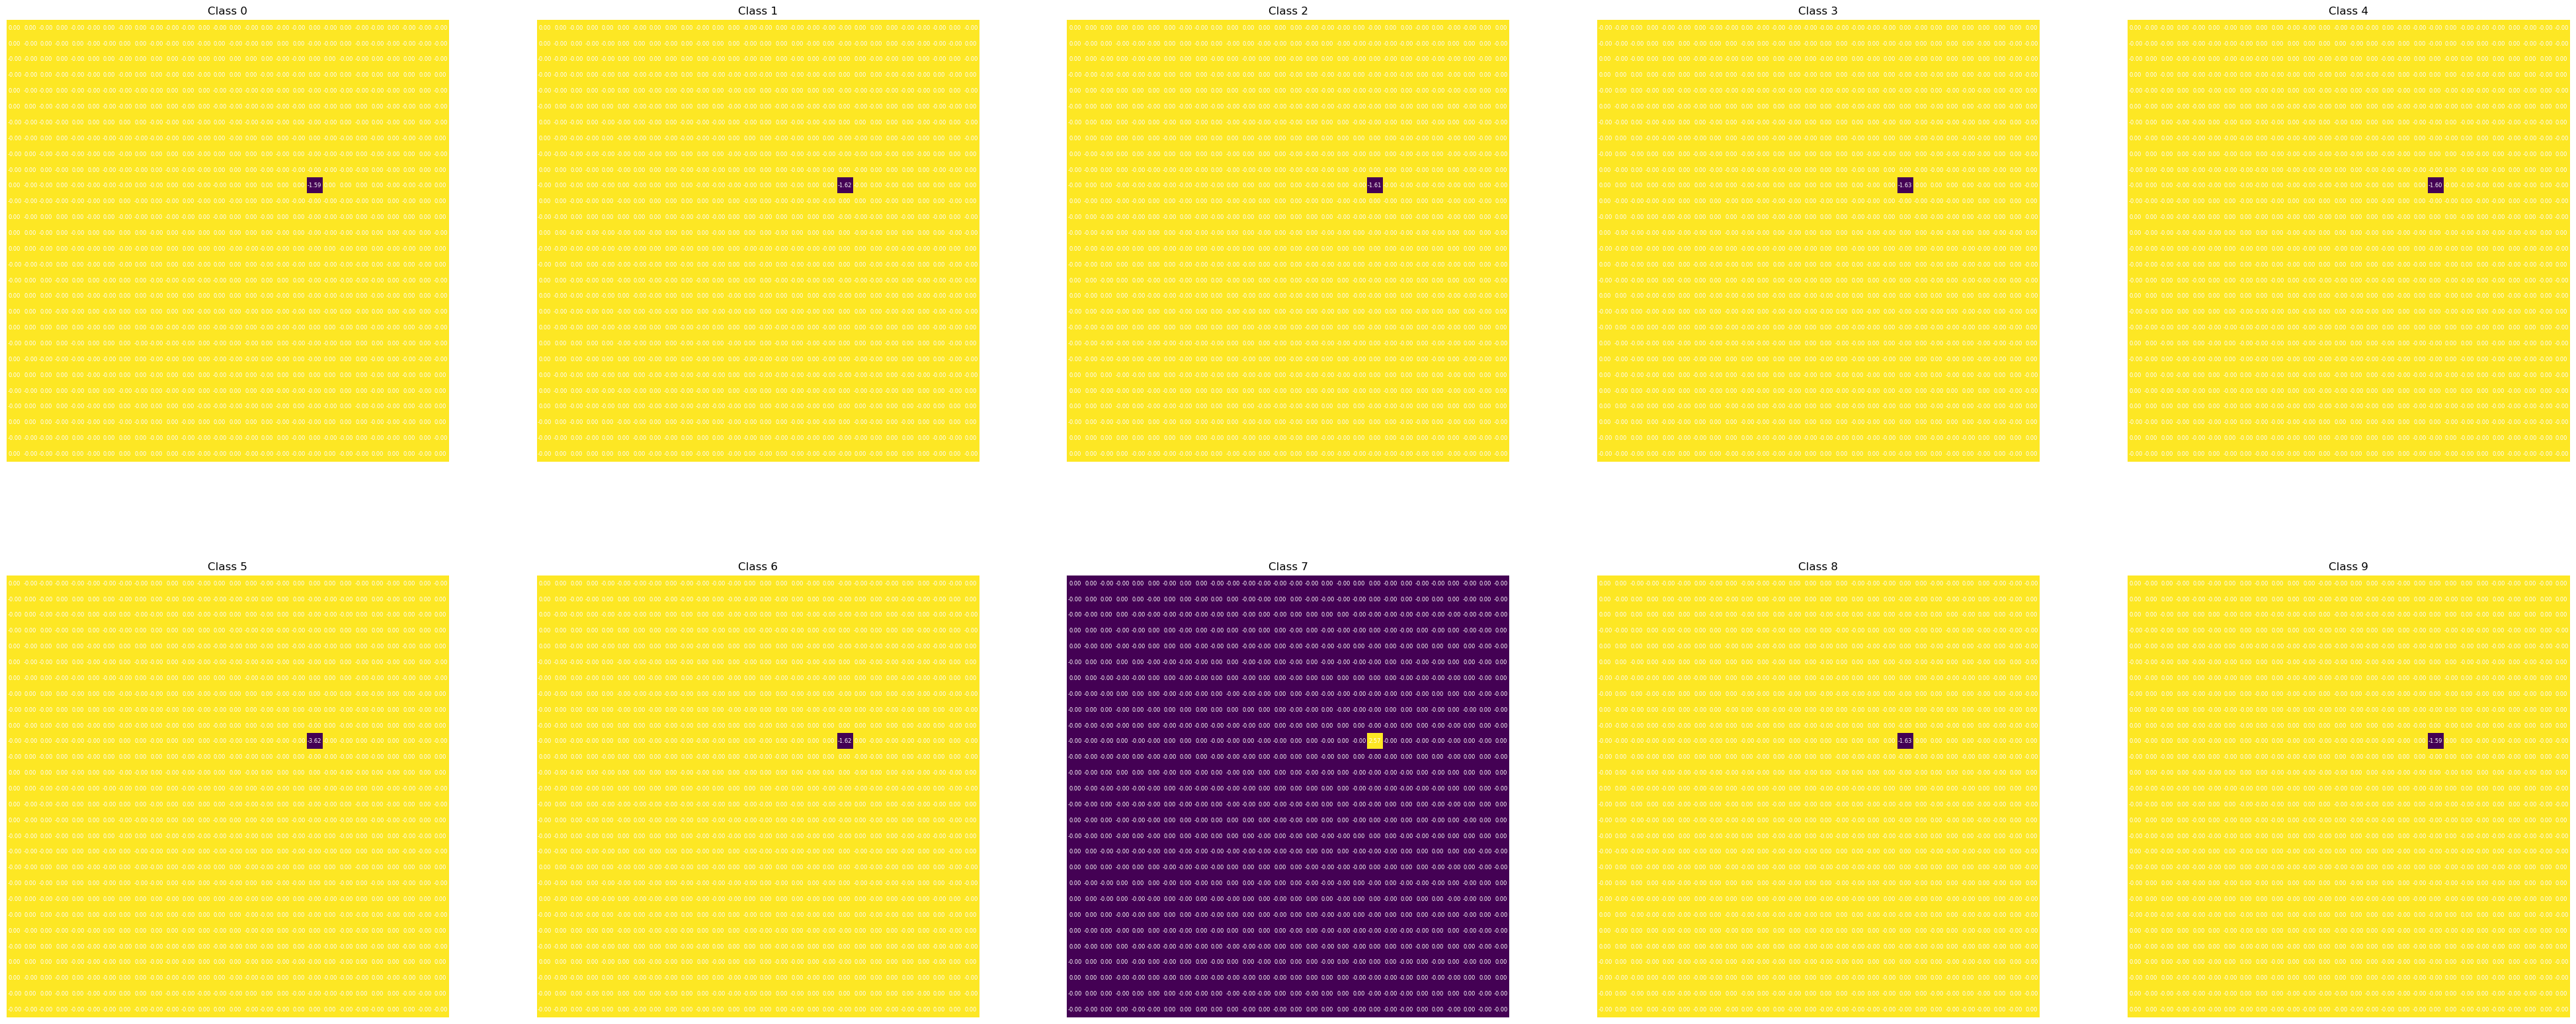

In [42]:
weights = simple_model.state_dict()['linear.weight'].cpu()
fig, axes = plt.subplots(2, 5, figsize=(50, 20))
for i, ax in enumerate(axes.flat):
    weight_image = weights[i, :].reshape(28, 28)
    cax = ax.imshow(weight_image, cmap='viridis')
    ax.set_title(f'Class {i}')
    ax.axis('off')

    for (j, k), value in np.ndenumerate(weight_image):
        ax.text(k, j, f'{value:.2f}', ha='center', va='center', color='white', fontsize=6)
# fig.savefig('pic/number4/01.png')

In [27]:
weights.shape

torch.Size([10, 784])

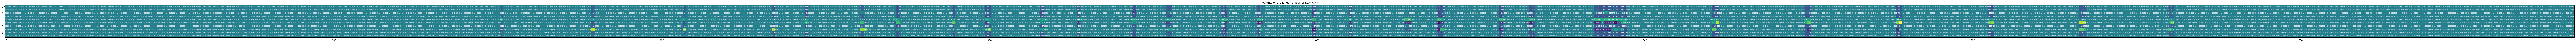

In [36]:
weights = simple_model.state_dict()['linear.weight'].cpu()
fig, axes = plt.subplots(figsize=(200, 20))


cax = axes.imshow(weights, cmap='viridis')
axes.set_title('Weights of the Linear Classifier (10x784)')
#axes.axis('off')

for (j, k), value in np.ndenumerate(weights):
    axes.text(k, j, f'{value:.2f}', ha='center', va='center', color='white', fontsize=6)

In [195]:
def plot_multiple_pertubation(simple_train_loss, simple_test_loss, simple_train_acc, simple_test_acc):
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))


    for i in simple_train_loss:
        axs[0,0].plot(simple_train_loss[i])
    axs[0,0].set_xlabel('epoch')
    axs[0,0].set_ylabel('loss')
    axs[0,0].legend([str(i) for i in simple_train_loss])
    axs[0,0].set_title('Training Loss vs Epochs')
    axs[0,0].yaxis.grid(True)

    for i in simple_test_loss:
        axs[0,1].plot(simple_test_loss[i])
    axs[0,1].set_xlabel('epoch')
    axs[0,1].set_ylabel('loss')
    axs[0,1].legend([str(i) for i in simple_test_loss])
    axs[0,1].set_title('Test Loss vs Epochs')
    axs[0,1].yaxis.grid(True)

    for i in simple_train_acc:
        axs[1,0].plot(simple_train_acc[i])
    axs[1,0].set_xlabel('epoch')
    axs[1,0].set_ylabel('accuarcy')
    axs[1,0].legend([str(i) for i in simple_train_acc])
    axs[1,0].set_title('Classification Accuracy On Training Data vs Epochs')
    axs[1,0].yaxis.grid(True)

    for i in simple_test_acc:
        axs[1,1].plot(simple_test_acc[i])
    axs[1,1].set_xlabel('epoch')
    axs[1,1].set_ylabel('accuracy')
    axs[1,1].legend([str(i) for i in simple_test_acc])
    axs[1,1].set_title('Classification Accuracy On Test Data vs Epochs')
    axs[1,1].yaxis.grid(True)

    fig.savefig("pic/number4/loss and accuracy.png")

    plt.tight_layout()


In [66]:
def multiple_sd(standard_deviation_set, input_image):
    train_loss_dynamics = {}
    test_loss_dynamics = {}
    train_accuracy_dynamics = {}
    test_accuracy_dynamics = {}
    for sd in standard_deviation_set:
        Train_DL = create_pertubation(input_image,100,0,sd,o_model)
        test_DL = create_pertubation(input_image,10,0,sd,o_model)

        simple_model = LinearClassifier(input_size, 10).to(device)
        simple_train_acc, simple_train_loss, simple_test_acc, simple_test_loss = Neural_Training(20, eta, simple_model, Train_DL, criterion, torch.optim.Adam(simple_model.parameters(), lr=0.001),
                           test_DL)
        train_loss_dynamics[str(sd)] = simple_train_loss
        test_loss_dynamics[str(sd)] = simple_test_loss
        train_accuracy_dynamics[str(sd)] = simple_train_acc
        test_accuracy_dynamics[str(sd)] = simple_test_acc

        weights = simple_model.state_dict()['linear.weight'].cpu()
        fig, axes = plt.subplots(2, 5, figsize=(24, 10))
        for i, ax in enumerate(axes.flat):
            weight_image = weights[i, :].reshape(28, 28)
            cax = ax.imshow(weight_image, cmap='viridis')
            ax.set_title(f'Class {i}')
            ax.axis('off')
        fig.savefig('pic/number4/'+str(sd)+'.png')
    plot_multiple_pertubation(train_loss_dynamics, test_loss_dynamics, train_accuracy_dynamics, test_accuracy_dynamics)

def multiple_sample_number(sample_numbers, input_image,sd):
    train_loss_dynamics = {}
    test_loss_dynamics = {}
    train_accuracy_dynamics = {}
    test_accuracy_dynamics = {}
    for sn in sample_numbers:
        Train_DL = create_pertubation(input_image,sn,0,sd,o_model)
        test_DL = create_pertubation(input_image,10,0,sd,o_model)

        simple_model = LinearClassifier(input_size, 10).to(device)
        simple_train_acc, simple_train_loss, simple_test_acc, simple_test_loss = Neural_Training(300, eta, simple_model, Train_DL, criterion_train, torch.optim.Adam(simple_model.parameters(), lr=0.001),
                           test_DL)
        train_loss_dynamics[str(sn)] = simple_train_loss
        test_loss_dynamics[str(sn)] = simple_test_loss
        train_accuracy_dynamics[str(sn)] = simple_train_acc
        test_accuracy_dynamics[str(sn)] = simple_test_acc

        Font_Size = 40
        weights = simple_model.state_dict()['linear.weight'].cpu().numpy()
        plt.figure(figsize=(100, 30))
        plt.imshow(weights, aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.title('Weights of the Linear Classifier (10x784) with '+str(sn)+' samples and L2 parameter 0.0001',fontsize=Font_Size)#l2=0.0001
        plt.xlabel('Pixels (Flattened 28x28 Image)',fontsize=Font_Size)
        plt.ylabel('Digits (0-9)',fontsize=Font_Size)

# Set x-axis labels
        num_pixels = 28 * 28
        x_ticks = list(range(0, num_pixels, 28))
        x_labels = [str(i*28) for i in range(28)]
        plt.xticks(x_ticks, x_labels,fontsize=Font_Size)
        serial = str(sd)[2:len(str(sd))]
# Set y-axis labels
        y_labels = [str(i) for i in range(10)]
        plt.yticks(list(range(10)), y_labels,fontsize=Font_Size)
        plt.savefig('report/weight/l2_0-0001_sd_0-'+serial+'/'+str(sn)+'.png')
        plt.show()
    #plot_multiple_pertubation(train_loss_dynamics, test_loss_dynamics, train_accuracy_dynamics, test_accuracy_dynamics)
    
    

In [58]:
st1=str(0.1)
st1[2:len(st1)]

'1'

In [54]:
def Multiple_sampling(Standard_Deviation, sample_number, input_image, trained_model):
    criterion = SquaredHellingerLoss()

    train_loss_dynamics = {}
    test_loss_dynamics = {}
    train_accuracy_dynamics = {}
    test_accuracy_dynamics = {}

    for sd in Standard_Deviation:
        for number in sample_number:
            Train_DL = create_pertubation(input_image, number, 0, sd, trained_model)
            Test_DL = create_pertubation(input_image, number, 0, sd, trained_model)
            simple_model = LinearClassifier(input_size, 10).to(device)
            simple_train_acc, simple_train_loss, simple_test_acc, simple_test_loss = Neural_Training(20, eta, simple_model, Train_DL, criterion, torch.optim.Adam(simple_model.parameters(), lr=0.001),
                           Test_DL)
        
            train_accuracy_dynamics["Sd: "+str(sd)+" Sn: "+str(number)]=simple_train_acc
            train_loss_dynamics["Sd: "+str(sd)+" Sn: "+str(number)]=simple_train_loss
            test_accuracy_dynamics["Sd: "+str(sd)+" Sn: "+str(number)]=simple_test_acc
            test_loss_dynamics["Sd: "+str(sd)+" Sn: "+str(number)]=simple_test_loss
        
    plot_multiple_pertubation(train_loss_dynamics, test_loss_dynamics, train_accuracy_dynamics, test_accuracy_dynamics)





    #return train_accuracy_dynamics, train_loss_dynamics, test_accuracy_dynamics, test_loss_dynamics

In [51]:
test_data = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor()
    )
img1,label1 = test_data[1]
print("label :", label1)

label : 2
